=== Temperature sensing summary ===
Files processed: 8
Temperatures (°C): [25.0, 31.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0]
S (percent): [1.484088, 1.439485, 1.373667, 1.309887, 1.24096, 1.107154, 1.132139, 0.913684]
S uncertainties (percent): [0.187981, 0.166065, 0.19724, 0.173868, 0.193555, 0.19059, 0.203101, 0.196781]

=== S vs Temperature fit ===
  slope mS = -1.546658e-02 (% / °C) ± 1.434529e-03
  intercept cS = 1.909400e+00 (%) ± 6.206704e-02
  residual noise (S) = 4.115862e-02 %
  Sensitivity from S-slope (°C/√Hz) for τ=300 ms: 1.457562e+00

=== Fractional change (ΔS/S)_% vs Temperature fit ===
  slope mf = -1.042160e+00 (% / °C) ± 9.666060e-02
  intercept cf = 2.865809e+01 (%) ± 4.182166e+00
  residual noise (frac) = 2.773326e+00 %
  Sensitivity from fractional-slope (°C/√Hz) for τ=300 ms: 1.457562e+00

Saved results table: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\2nd Oct NaBiF4\temperature sensing\temperature_analysis_S_and_frac_results.csv


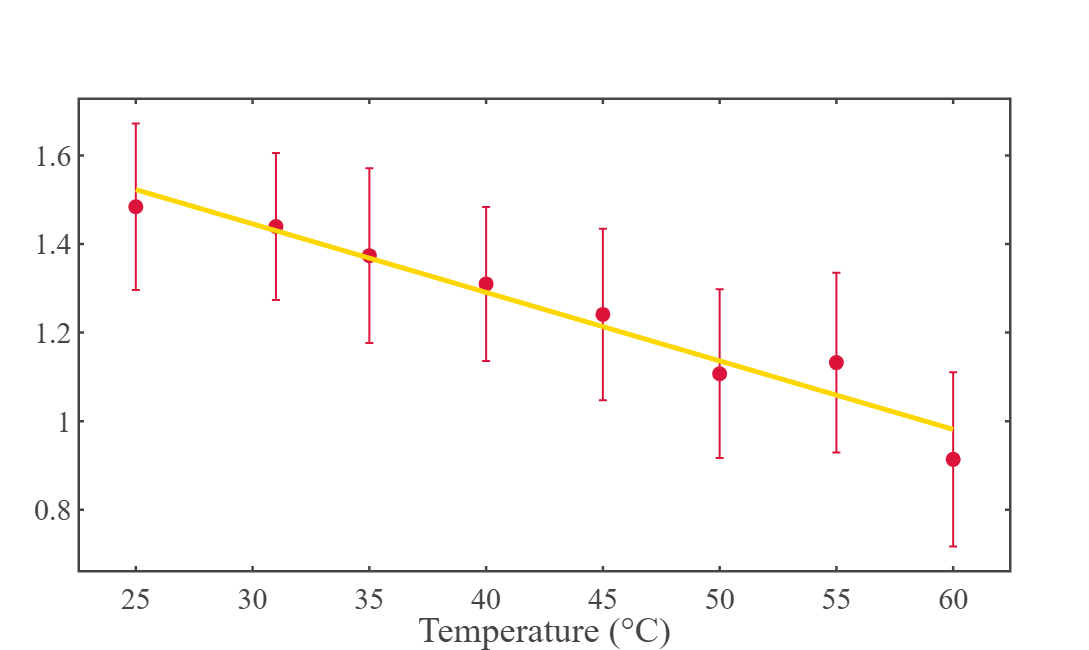

Saved: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\S_vs_Temp.png


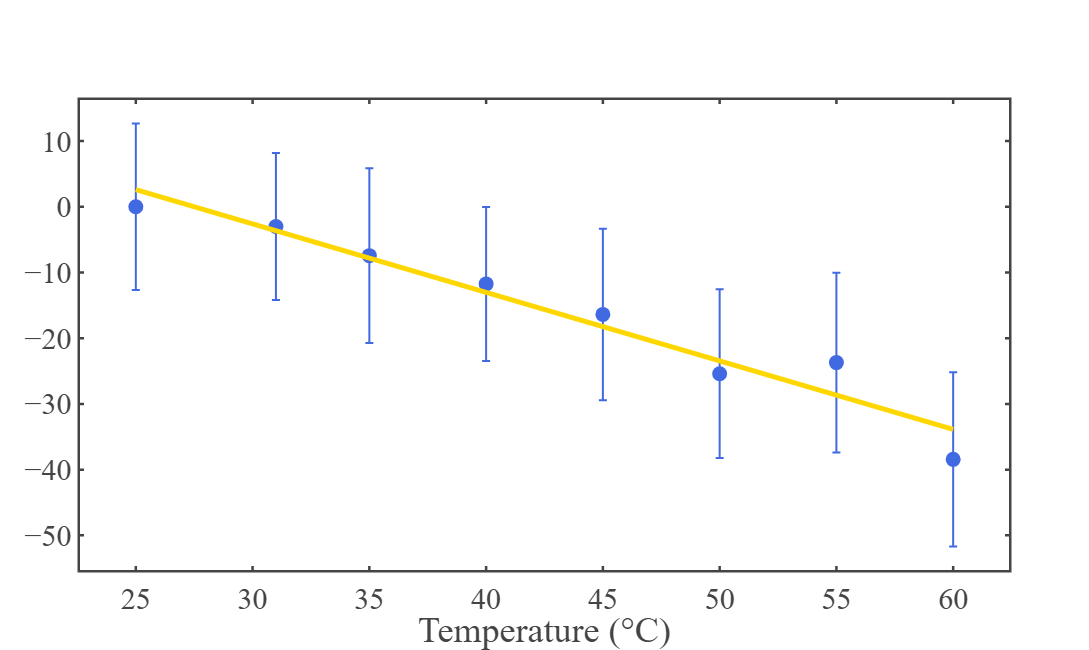

Saved: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\DeltaSbyS_vs_Temp.png


In [31]:
import numpy as np
import pandas as pd
import os
import re
import plotly.graph_objects as go
import plotly.io as pio

# ============================================================
# --- Figure Template (kept identical to your style) ---
# ============================================================
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False,'zerolinecolor':'white'},
    'yaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False,'zerolinecolor':'white'},
    'font': {'family':'mathjax','size':30}
}

# ============================================================
# --- Parameters: temperature folder & patterns ---
# ============================================================
folder_path = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\2nd Oct NaBiF4\temperature sensing"
temp_pattern = re.compile(r"(\d+)degree")   # e.g. 25degree

output_fig_folder = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper"
os.makedirs(output_fig_folder, exist_ok=True)

# Time windows (ms) — same as your protocol
groups = [(21, 24), (46, 49), (71, 74), (96, 99)]

# Integration time for sensitivity
tau = 0.300  # seconds (300 ms)

# ============================================================
# --- Helper functions (matching your pipeline) ---
# ============================================================
def extract_mean_std(file_path):
    """
    Load a two-column text file (header present) and compute
    S = 100*(mean1 - mean2)/mean1 and propagated std in percent.
    Assumes first column = Time (ps), second column = Counts per bin.
    """
    arr = np.loadtxt(file_path, skiprows=1)
    # keep behavior identical to your previous code:
    time_ms = arr[:, 0] / 1e9
    intensity = arr[:, 1]

    regions = []
    for (t1, t2) in groups:
        mask = (time_ms >= t1) & (time_ms <= t2)
        vals = intensity[mask]
        if len(vals) == 0:
            vals = np.array([np.nan])
        regions.append(vals)

    g1 = np.concatenate([regions[0], regions[2]])
    g2 = np.concatenate([regions[1], regions[3]])

    mean1, std1 = np.nanmean(g1), np.nanstd(g1)
    mean2, std2 = np.nanmean(g2), np.nanstd(g2)

    if np.isfinite(mean1) and mean1 > 0:
        signal = 100.0 * (mean1 - mean2) / mean1
        ds_dm1 = 100.0 * (mean2 / (mean1 ** 2))
        ds_dm2 = -100.0 / mean1
        signal_std = np.sqrt((ds_dm1 * std1) ** 2 + (ds_dm2 * std2) ** 2)
    else:
        signal, signal_std = np.nan, np.nan

    return signal, signal_std

def linear_fit_with_uncertainty(x, y, weights=None):
    """
    Weighted linear fit via numpy.polyfit(..., cov=True).
    Returns slope m, intercept c and their uncertainties sm, sc.
    If not enough points returns nans.
    """
    mask = np.isfinite(x) & np.isfinite(y)
    x_valid, y_valid = np.array(x)[mask], np.array(y)[mask]
    if len(x_valid) < 2:
        return np.nan, np.nan, np.nan, np.nan
    if weights is not None:
        w_valid = np.array(weights)[mask]
        p, cov = np.polyfit(x_valid, y_valid, 1, w=w_valid, cov=True)
    else:
        p, cov = np.polyfit(x_valid, y_valid, 1, cov=True)
    m, c = p[0], p[1]
    sm = np.sqrt(cov[0, 0]) if cov is not None else np.nan
    sc = np.sqrt(cov[1, 1]) if cov is not None else np.nan
    return m, c, sm, sc

# ============================================================
# --- Loop through folder, compute S and uncertainties ---
# ============================================================
temps = []
S_vals = []
S_stds = []
file_list = []

for fname in os.listdir(folder_path):
    if not fname.lower().endswith(".txt"):
        continue
    m = temp_pattern.search(fname)
    if not m:
        continue
    temp = float(m.group(1))
    fpath = os.path.join(folder_path, fname)
    try:
        S, S_std = extract_mean_std(fpath)
    except Exception as e:
        print(f"Skipping {fname} due to load/extract error: {e}")
        continue
    temps.append(temp)
    S_vals.append(S)
    S_stds.append(S_std)
    file_list.append(fname)

# Sort by temperature
if len(temps) == 0:
    raise RuntimeError("No temperature files found. Check folder_path and filename pattern.")

order = np.argsort(temps)
temps = np.array(temps)[order]
S_vals = np.array(S_vals)[order]
S_stds = np.array(S_stds)[order]
file_list = [file_list[i] for i in order]

# ============================================================
# --- Fractional change relative to lowest temperature ---
# ============================================================
S_ref = S_vals[0]
frac_change_percent = (S_vals - S_ref) / S_ref * 100.0
# propagate uncertainty (approx): d((S-Sref)/Sref)/dS = 1/Sref
frac_std = (S_stds / S_ref) * 100.0

# ============================================================
# --- Linear fit: S vs Temperature ---
# ============================================================
weights_S = None
if np.all(np.isfinite(S_stds)) and np.all(S_stds > 0):
    weights_S = 1.0 / S_stds

mS, cS, smS, scS = linear_fit_with_uncertainty(temps, S_vals, weights=weights_S)
t_fit = np.linspace(np.nanmin(temps), np.nanmax(temps), 200)
S_fit = mS * t_fit + cS

# Residual noise for S fit (in percent)
residuals_S = S_vals - (mS * temps + cS)
noise_S = np.nanstd(residuals_S)

if np.isfinite(mS) and abs(mS) > 0:
    sensitivity_S = (noise_S / abs(mS)) * np.sqrt(tau)
else:
    sensitivity_S = np.nan

# ============================================================
# --- Linear fit: fractional change (ΔS/S)_% vs Temperature ---
# ============================================================
weights_frac = None
if np.all(np.isfinite(frac_std)) and np.all(frac_std > 0):
    weights_frac = 1.0 / frac_std

mf, cf, smf, scf = linear_fit_with_uncertainty(temps, frac_change_percent, weights=weights_frac)
frac_fit = mf * t_fit + cf

# Residual noise for fractional fit (in percent)
residuals_frac = frac_change_percent - (mf * temps + cf)
noise_frac = np.nanstd(residuals_frac)

if np.isfinite(mf) and abs(mf) > 0:
    sensitivity_frac = (noise_frac / abs(mf)) * np.sqrt(tau)
else:
    sensitivity_frac = np.nan

# ============================================================
# --- Print results summary ---
# ============================================================
print("=== Temperature sensing summary ===")
print(f"Files processed: {len(temps)}")
print(f"Temperatures (°C): {temps.tolist()}")
print(f"S (percent): {np.round(S_vals,6).tolist()}")
print(f"S uncertainties (percent): {np.round(S_stds,6).tolist()}")
print()
print("=== S vs Temperature fit ===")
print(f"  slope mS = {mS:.6e} (% / °C) ± {smS:.6e}")
print(f"  intercept cS = {cS:.6e} (%) ± {scS:.6e}")
print(f"  residual noise (S) = {noise_S:.6e} %")
print(f"  Sensitivity from S-slope (°C/√Hz) for τ={tau*1000:.0f} ms: {sensitivity_S:.6e}")
print()
print("=== Fractional change (ΔS/S)_% vs Temperature fit ===")
print(f"  slope mf = {mf:.6e} (% / °C) ± {smf:.6e}")
print(f"  intercept cf = {cf:.6e} (%) ± {scf:.6e}")
print(f"  residual noise (frac) = {noise_frac:.6e} %")
print(f"  Sensitivity from fractional-slope (°C/√Hz) for τ={tau*1000:.0f} ms: {sensitivity_frac:.6e}")
print()

# ============================================================
# --- Save numeric results to CSV ---
# ============================================================
out_tab = pd.DataFrame({
    "filename": file_list,
    "Temperature_C": temps,
    "S_percent": S_vals,
    "S_std_percent": S_stds,
    "DeltaSbyS_percent": frac_change_percent,
    "DeltaSbyS_std_percent": frac_std
})
out_csv = os.path.join(folder_path, "temperature_analysis_S_and_frac_results.csv")
out_tab.to_csv(out_csv, index=False)
print("Saved results table:", out_csv)

# ============================================================
# --- Plots ---
# ============================================================
# S vs Temperature (with fit)
figS = go.Figure()
figS.add_trace(go.Scatter(
    x=temps,
    y=S_vals,
    error_y=dict(type='data', array=S_stds, visible=True),
    mode='markers',
    marker=dict(size=15, color='crimson'),
    name='S (%)',
    showlegend =False,
))
if np.isfinite(mS):
    figS.add_trace(go.Scatter(x=t_fit, y=S_fit, 
                              mode='lines', 
                              line=dict(color='gold', width=5),
                              name=f"S-fit: m={mS:.3e} %/°C",
    showlegend =False,))
figS.update_layout(template=fig_template, 
                   # title="S (%) vs Temperature",
                   xaxis_title="Temperature (°C)", 
                   # yaxis_title="(ΔS/S) (%)", 
                   width=800, height=650)
outS = os.path.join(output_fig_folder, "S_vs_Temp.png")
pio.write_image(figS, outS, scale=4)
figS.show()
print("Saved:", outS)

# Fractional change plot (with fit)
figF = go.Figure()
figF.add_trace(go.Scatter(
    x=temps,
    y=frac_change_percent,
    error_y=dict(type='data', array=frac_std, visible=True),
    mode='markers',
    marker=dict(size=15, color='royalblue'),
    name='(ΔS/S) (%)',
    showlegend =False,
))
if np.isfinite(mf):
    figF.add_trace(go.Scatter(x=t_fit, y=frac_fit, 
                              mode='lines', 
                              line=dict(color='gold', width=5),
                              name=f'Fit: m={mf:.3e} %/°C',
                            showlegend =False,))
figF.update_layout(template=fig_template, 
                   # title="Fractional change (ΔS/S) (%) vs Temperature",
                   xaxis_title="Temperature (°C)", 
                   # yaxis_title="(ΔS/S) (%)", 
                   width=800, height=650)
outF = os.path.join(output_fig_folder, "DeltaSbyS_vs_Temp.png")
pio.write_image(figF, outF, scale=4)
figF.show()
print("Saved:", outF)

# ============================================================
# --- End ---
# ============================================================


Saved figure: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\curves_25_60deg.png


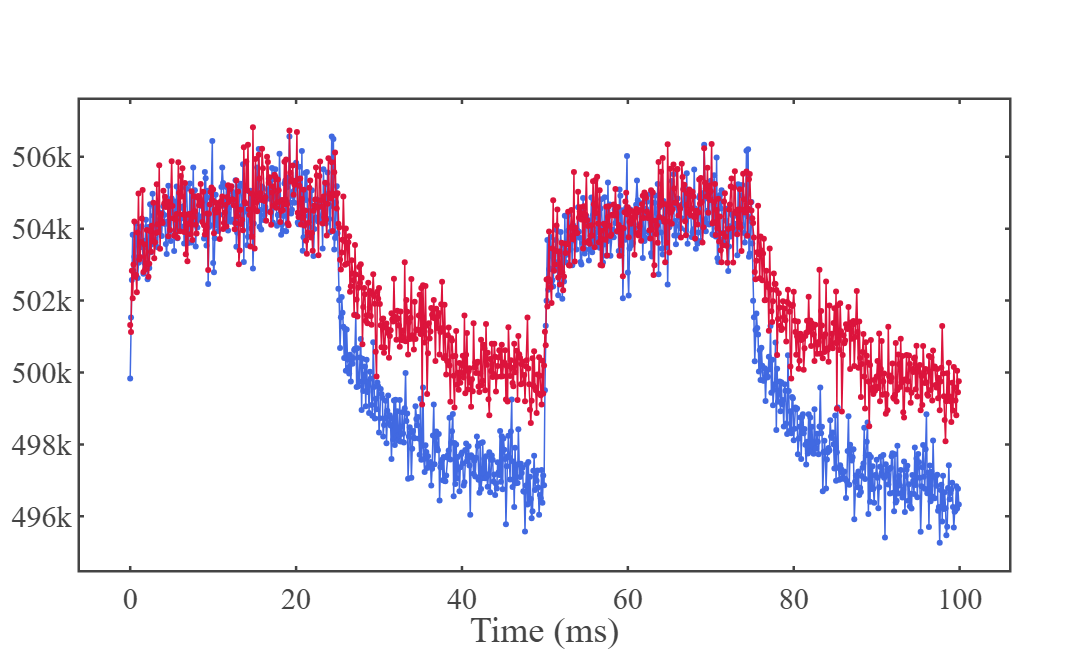

In [59]:
# ============================================================
# --- Plot raw curves for 25°C and 60°C, aligned at group 1 ---
# ============================================================
target_temps = [25, 60]  # temperatures to plot
colors = ['royalblue', 'crimson']  # 25°C = royalblue, 60°C = crimson
markers = ['circle', 'circle']      # circle marker for both

# group 1 window in ms (first tuple of groups)
t1, t2 = groups[0]

fig = go.Figure()

mean_group1 = []

for i, temp in enumerate(target_temps):
    # find file corresponding to this temperature
    idx = np.where(temps == temp)[0]
    if len(idx) == 0:
        print(f"Temperature {temp}°C not found in data.")
        continue
    idx = idx[0]
    file_path = os.path.join(folder_path, file_list[idx])
    arr = np.loadtxt(file_path, skiprows=1)
    
    # time in ms, intensity
    time_ms = arr[:, 0] / 1e9
    intensity = arr[:, 1]
    
    # compute mean of group 1
    mask_group1 = (time_ms >= t1) & (time_ms <= t2)
    mean_g1 = np.nanmean(intensity[mask_group1])
    mean_group1.append(mean_g1)

# shift 60°C curve to match 25°C group1 mean
offset = mean_group1[0] - mean_group1[1]

for i, temp in enumerate(target_temps):
    idx = np.where(temps == temp)[0][0]
    file_path = os.path.join(folder_path, file_list[idx])
    arr = np.loadtxt(file_path, skiprows=1)
    time_ms = arr[:, 0] / 1e9
    intensity = arr[:, 1]
    
    if temp == 60:
        intensity += offset  # shift to match group1 mean
    
    fig.add_trace(go.Scatter(
        x=time_ms,
        y=intensity,
        mode='lines+markers',
        line=dict(color=colors[i], width=1.5),
        marker=dict(symbol=markers[i], size=6),
        name=f"{temp} °C",
        showlegend=False
    ))

# ============================================================
# --- Layout ---
# ============================================================
fig.update_layout(
    template=fig_template,
    xaxis_title="Time (ms)",
    width=800, height=650
)

out_path = os.path.join(output_fig_folder, "curves_25_60deg.png") 
pio.write_image(fig, out_path, scale=4)
print("Saved figure:", out_path)

fig.show()
